In [17]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
data = pd.read_csv('Online Retail.csv')
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [102]:


# مرحله 1: حذف محصولات تکراری بر اساس StockCode
data_unique = data.drop_duplicates(subset=['StockCode']).reset_index(drop=True)

# مرحله 2: حذف یا جایگزینی مقادیر NaN در ستون Description
data_unique['Description'] = data_unique['Description'].fillna('')

# مرحله 3: اعمال TF-IDF روی توضیحات یکتای محصولات
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_description = tfidf_vectorizer.fit_transform(data_unique['Description'])

# نرمال‌سازی UnitPrice برای اضافه شدن به ویژگی‌ها
unit_price_scaled = (data_unique['UnitPrice'] - data_unique['UnitPrice'].min()) / (data_unique['UnitPrice'].max() - data_unique['UnitPrice'].min())

# ترکیب ماتریس TF-IDF و UnitPrice نرمال‌شده
tfidf_matrix_combined = np.hstack((tfidf_matrix_description.toarray(), unit_price_scaled.values.reshape(-1, 1)))

# محاسبه شباهت کسینوسی بین محصولات (همراه با قیمت)
cosine_sim = cosine_similarity(tfidf_matrix_combined, tfidf_matrix_combined)

# انتخاب تصادفی یک محصول
product_index = random.randint(0, len(data_unique) - 1)
selected_product = data_unique.iloc[product_index][['StockCode', 'Description', 'UnitPrice']]
print("Selected Product:")
print(selected_product)

# دریافت محصولات مشابه با محصول انتخاب‌شده
similar_products = list(enumerate(cosine_sim[product_index]))
similar_products = sorted(similar_products, key=lambda x: x[1], reverse=True)

# فیلتر کردن محصولاتی با StockCode مشابه و بازیابی 5 پیشنهاد برتر
top_similar_products = [
    (item[0], item[1]) for item in similar_products[1:]  # حذف محصول اصلی
    if data_unique.iloc[item[0]]['StockCode'] != data_unique.iloc[product_index]['StockCode']
][:5]

# بازیابی جزئیات محصولات به همراه امتیاز شباهت
recommended_products = pd.DataFrame([
    {
        "StockCode": data_unique.iloc[item[0]]['StockCode'],
        "Description": data_unique.iloc[item[0]]['Description'],
        "UnitPrice": data_unique.iloc[item[0]]['UnitPrice'],
        "Cosine Similarity Score": item[1]
    }
    for item in top_similar_products
])

# نمایش محصول انتخاب‌شده و پیشنهادات آن
print("\nRecommended Products:")
print(recommended_products)


Selected Product:
StockCode                          21069
Description    VINTAGE BILLBOARD TEA MUG
UnitPrice                           1.25
Name: 1004, dtype: object

Recommended Products:
  StockCode                      Description  UnitPrice  \
0     21070           VINTAGE BILLBOARD MUG        1.25   
1     21071   VINTAGE BILLBOARD DRINK ME MUG       1.06   
2     21068  VINTAGE BILLBOARD LOVE/HATE MUG       1.06   
3     21066                  VINTAGE RED MUG       1.25   
4     22983              CARD BILLBOARD FONT       0.42   

   Cosine Similarity Score  
0                 0.880400  
1                 0.674230  
2                 0.611994  
3                 0.493383  
4                 0.442282  


In [103]:


# مرحله 1: حذف محصولات تکراری براساس کد محصول (StockCode)
data_unique = data.drop_duplicates(subset=['StockCode'])

# مرحله 2: حذف ردیف‌های دارای NaN در ستون Description
data_unique = data_unique.dropna(subset=['Description'])

# مرحله 2: اعمال TF-IDF بر روی توضیحات محصولات
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(data_unique['Description'])

# مرحله 3: محاسبه شباهت کسینوسی بین محصولات
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# دریافت شاخص تصادفی برای محصول انتخاب‌شده
# product_index = random.randint(0, len(data_unique) - 1)

# دریافت جزئیات محصول انتخاب شده
selected_product = data_unique.iloc[product_index][['StockCode', 'Description', 'UnitPrice']]
print("Selected Product:")
print(selected_product)

# مرحله 5: پیدا کردن مشتریانی که محصول انتخاب‌شده را خریداری کرده‌اند
selected_stock_code = selected_product['StockCode']

# تعریف cleaned_data
cleaned_data = data.dropna(subset=['CustomerID', 'StockCode'])

purchased_customers = cleaned_data[cleaned_data['StockCode'] == selected_stock_code]['CustomerID'].unique()

# انتخاب تصادفی یک مشتری
if len(purchased_customers) > 0:
    selected_customer_id = random.choice(purchased_customers)
    print(f"\nSelected CustomerID: {selected_customer_id}")
else:
    selected_customer_id = None
    print("\nNo customers found for this product.")

# مرحله 6: فیلترینگ مشارکتی برای مشتری انتخاب شده
if selected_customer_id:  # اطمینان از وجود مشتری انتخاب‌شده
    def recommend_products(customer_id, interaction_matrix, customer_similarity, top_n=5):
        # دریافت شاخص مشتری انتخاب‌شده در ماتریس تعامل
        customer_idx = interaction_matrix.index.get_loc(customer_id)
        
        # پیدا کردن مشتریان مشابه براساس شباهت کسینوسی
        similar_customers = list(enumerate(customer_similarity[customer_idx]))
        similar_customers = sorted(similar_customers, key=lambda x: x[1], reverse=True)
        
        # انتخاب مشتریان مشابه برتر (به‌جز مشتری خود)
        top_similar_customers = [item[0] for item in similar_customers[1:top_n+1]]
        
        # جمع‌آوری محصولاتی که مشتریان مشابه خریداری کرده‌اند
        recommendations = interaction_matrix.iloc[top_similar_customers].sum(axis=0)
        
        # حذف محصولاتی که مشتری انتخاب‌شده قبلاً خریداری کرده است
        purchased_products = interaction_matrix.iloc[customer_idx] > 0
        recommendations = recommendations[~purchased_products]
        
        # بازگشت محصولات پیشنهادی برتر
        return recommendations.sort_values(ascending=False).head(top_n)

    # تولید پیشنهادات برای مشتری انتخاب‌شده
    collab_recommendations = recommend_products(selected_customer_id, interaction_matrix, customer_similarity)

    # نمایش جزئیات محصولات پیشنهادی همراه با امتیازات مشارکتی
    recommended_details = data[data['StockCode'].isin(collab_recommendations.index)][['StockCode', 'Description', 'UnitPrice']].drop_duplicates()
    recommended_details['Collaborative Score'] = recommended_details['StockCode'].map(collab_recommendations)
    
    # اصلاحات:
    # حذف محصولات تکراری بر اساس StockCode
    recommended_details = recommended_details.drop_duplicates(subset=['StockCode'])

    # حذف محصولات با توضیحات نامعتبر
    recommended_details = recommended_details[
        ~recommended_details['Description'].str.lower().isin(['?', 'incorrectly made-thrown away'])
    ]

    # حذف محصولات با قیمت صفر
    recommended_details = recommended_details[recommended_details['UnitPrice'] > 0]

    # مرتب‌سازی جزئیات براساس امتیازات مشارکتی
    recommended_details = recommended_details.sort_values(by='Collaborative Score', ascending=False)

    print("\nCleaned Collaborative Filtering Recommendations:")
    print(recommended_details)
else:
    print("\nNo valid customer selected for collaborative filtering.")


Selected Product:
StockCode                          21069
Description    VINTAGE BILLBOARD TEA MUG
UnitPrice                           1.25
Name: 3381, dtype: object

Selected CustomerID: 16705.0

Cleaned Collaborative Filtering Recommendations:
     StockCode                      Description  UnitPrice  \
455      48194                   DOORMAT HEARTS       7.95   
1352     21524   DOORMAT SPOTTY HOME SWEET HOME       7.95   
18       21755         LOVE BUILDING BLOCK WORD       5.95   
854     48173C             DOORMAT BLACK FLOCK        7.95   
46       22086  PAPER CHAIN KIT 50'S CHRISTMAS        2.55   

      Collaborative Score  
455                    11  
1352                   11  
18                      9  
854                     9  
46                      8  


In [105]:


# --- مرحله 1: آماده‌سازی داده‌ها ---
# خواندن داده‌ها

# حذف محصولات تکراری و حذف NaN
data_unique = data.drop_duplicates(subset=['StockCode']).dropna(subset=['Description']).reset_index(drop=True)

# محاسبه TF-IDF برای توضیحات محصولات
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_description = tfidf_vectorizer.fit_transform(data_unique['Description'])

# نرمال‌سازی قیمت محصول
unit_price_scaled = (data_unique['UnitPrice'] - data_unique['UnitPrice'].min()) / (
    data_unique['UnitPrice'].max() - data_unique['UnitPrice'].min()
)

# محاسبه شباهت کسینوسی
tfidf_matrix_combined = np.hstack((tfidf_matrix_description.toarray(), unit_price_scaled.values.reshape(-1, 1)))
cosine_sim = cosine_similarity(tfidf_matrix_combined, tfidf_matrix_combined)

# انتخاب تصادفی یک محصول
selected_product = data_unique.iloc[product_index][['StockCode', 'Description', 'UnitPrice']]
print("Selected Product:")
print(selected_product)

# دریافت محصولات مشابه با شباهت کسینوسی
similar_products = list(enumerate(cosine_sim[product_index]))
similar_products = sorted(similar_products, key=lambda x: x[1], reverse=True)[1:6]  # حذف محصول اصلی
cosine_recommendations = pd.DataFrame([
    {
        "StockCode": data_unique.iloc[item[0]]['StockCode'],
        "Cosine Similarity Score": item[1]
    }
    for item in similar_products
])

# --- مرحله 2: امتیازات مشارکتی ---
selected_stock_code = selected_product['StockCode']
cleaned_data = data.dropna(subset=['CustomerID', 'StockCode'])

# ایجاد ماتریس تعامل و محاسبه شباهت مشتری
interaction_matrix = pd.crosstab(cleaned_data['CustomerID'], cleaned_data['StockCode'])
customer_similarity = cosine_similarity(interaction_matrix.values)

# انتخاب تصادفی یک مشتری
purchased_customers = cleaned_data[cleaned_data['StockCode'] == selected_stock_code]['CustomerID'].unique()
if len(purchased_customers) > 0:
    selected_customer_id = random.choice(purchased_customers)
    print(f"\nSelected CustomerID: {selected_customer_id}")

    # پیشنهاد محصولات بر اساس فیلترینگ مشارکتی
    def recommend_products(customer_id, interaction_matrix, customer_similarity, top_n=5):
        customer_idx = interaction_matrix.index.get_loc(customer_id)
        similar_customers = list(enumerate(customer_similarity[customer_idx]))
        similar_customers = sorted(similar_customers, key=lambda x: x[1], reverse=True)[1:top_n+1]
        top_similar_customers = [item[0] for item in similar_customers]
        recommendations = interaction_matrix.iloc[top_similar_customers].sum(axis=0)
        purchased_products = interaction_matrix.iloc[customer_idx] > 0
        recommendations = recommendations[~purchased_products]
        return recommendations.sort_values(ascending=False).head(top_n)

    collab_recommendations = recommend_products(selected_customer_id, interaction_matrix, customer_similarity)
    collaborative_recommendations = pd.DataFrame({
        "StockCode": collab_recommendations.index,
        "Collaborative Score": collab_recommendations.values
    })
else:
    print("\nNo customers found for this product.")
    collaborative_recommendations = pd.DataFrame(columns=["StockCode", "Collaborative Score"])

# --- مرحله 3: ترکیب امتیازات دو مدل ---
# نرمال‌سازی امتیازات
cosine_recommendations['Cosine Similarity Score'] /= cosine_recommendations['Cosine Similarity Score'].max()
collaborative_recommendations['Collaborative Score'] /= collaborative_recommendations['Collaborative Score'].max()

# ترکیب امتیازات
combined_recommendations = pd.merge(
    cosine_recommendations,
    collaborative_recommendations,
    on="StockCode",
    how="outer"
).fillna(0)

# --- مرحله 4: مدل شبکه عصبی ---
X = combined_recommendations[['Cosine Similarity Score', 'Collaborative Score']].values
y = (0.7 * combined_recommendations['Cosine Similarity Score'] +
     0.3 * combined_recommendations['Collaborative Score']).values  # وزن‌دهی

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تعریف مدل
model = Sequential([
    Dense(64, activation='relu', input_dim=2),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # خروجی خطی برای پیش‌بینی نمره ترکیبی
])

# کامپایل مدل
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# اضافه کردن Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# آموزش مدل
model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=8, callbacks=[early_stopping], verbose=1)

# پیش‌بینی Hybrid Score
combined_recommendations['Hybrid Score'] = model.predict(X).flatten()

# مرتب‌سازی بر اساس Hybrid Score
final_recommendations = combined_recommendations.sort_values(by="Hybrid Score", ascending=False)

# اضافه کردن Description
final_recommendations = final_recommendations.merge(
    data_unique[['StockCode', 'Description']],
    on='StockCode',
    how='left'
)

# نمایش محصولات پیشنهادی
print("\nFinal Recommendations:")
print(final_recommendations[['StockCode', 'Description', 'Cosine Similarity Score', 'Collaborative Score', 'Hybrid Score']])


Selected Product:
StockCode                          21069
Description    VINTAGE BILLBOARD TEA MUG
UnitPrice                           1.25
Name: 1004, dtype: object

Selected CustomerID: 16915.0
Epoch 1/50


D:\Python 3.10.7\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.1103 - mae: 0.3141 - val_loss: 0.1173 - val_mae: 0.3256
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.1684 - mae: 0.2728 - val_loss: 0.0994 - val_mae: 0.2959
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1360 - mae: 0.2679 - val_loss: 0.0839 - val_mae: 0.2673
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1485 - mae: 0.3089 - val_loss: 0.0706 - val_mae: 0.2395
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1073 - mae: 0.2742 - val_loss: 0.0593 - val_mae: 0.2133
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.0664 - mae: 0.2256 - val_loss: 0.0497 - val_mae: 0.1881
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0531 - mae: 0.1979 - val_loss: 0.0415 - val_mae: 0.1636
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.0441 - mae: 0.1869 - val_loss: 0.0348 - val_mae: 0.1421
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.1083 - mae: 0.2501 - val_loss:

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score, r2_score
import numpy as np

# تعریف تابع ارزیابی
def evaluate_hybrid_model(y_true, y_pred_hybrid, y_pred_content, y_pred_collaborative, k=5):
    """
    ارزیابی مدل ترکیبی و مدل‌های جداگانه
    :param y_true: مقادیر واقعی
    :param y_pred_hybrid: امتیازات پیش‌بینی شده مدل ترکیبی
    :param y_pred_content: امتیازات پیش‌بینی شده مدل محتوا
    :param y_pred_collaborative: امتیازات پیش‌بینی شده مدل مشارکتی
    :param k: تعداد محصولات پیشنهادی برتر
    :return: نتایج شامل MSE, MAE, R2, NDCG
    """
    # محاسبه خطاها
    mse_hybrid = mean_squared_error(y_true, y_pred_hybrid)
    mae_hybrid = mean_absolute_error(y_true, y_pred_hybrid)
    r2_hybrid = r2_score(y_true, y_pred_hybrid)
    ndcg_hybrid = ndcg_score([y_true], [y_pred_hybrid], k=k)

    mse_content = mean_squared_error(y_true, y_pred_content)
    mae_content = mean_absolute_error(y_true, y_pred_content)
    r2_content = r2_score(y_true, y_pred_content)
    ndcg_content = ndcg_score([y_true], [y_pred_content], k=k)

    mse_collab = mean_squared_error(y_true, y_pred_collaborative)
    mae_collab = mean_absolute_error(y_true, y_pred_collaborative)
    r2_collab = r2_score(y_true, y_pred_collaborative)
    ndcg_collab = ndcg_score([y_true], [y_pred_collaborative], k=k)

    # بازگشت نتایج
    return {
        "Hybrid Model": {
            "MSE": mse_hybrid,
            "MAE": mae_hybrid,
            "R2": r2_hybrid,
            "NDCG@K": ndcg_hybrid
        },
        "Content-Based Model": {
            "MSE": mse_content,
            "MAE": mae_content,
            "R2": r2_content,
            "NDCG@K": ndcg_content
        },
        "Collaborative Model": {
            "MSE": mse_collab,
            "MAE": mae_collab,
            "R2": r2_collab,
            "NDCG@K": ndcg_collab
        }
    }


In [111]:
# بررسی وجود ستون True_Label
if 'True_Label' not in final_recommendations.columns:
    print("Warning: 'True_Label' not found. Creating it for testing purposes.")
    # مقداردهی تصادفی برای تست
    final_recommendations['True_Label'] = np.random.choice([0, 1], size=len(final_recommendations))

# ادامه کد ارزیابی
y_true = final_recommendations['True_Label'].values  # مقادیر واقعی
y_pred_hybrid = final_recommendations['Hybrid Score'].values
y_pred_content = final_recommendations['Cosine Similarity Score'].values
y_pred_collaborative = final_recommendations['Collaborative Score'].values

# اجرای ارزیابی
results = evaluate_hybrid_model(y_true, y_pred_hybrid, y_pred_content, y_pred_collaborative, k=5)

# نمایش نتایج
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric_name, metric_value in metrics.items():
        print(f"  {metric_name}: {metric_value:.4f}")



Hybrid Model:
  MSE: 0.1811
  MAE: 0.4025
  R2: -1.0124
  NDCG@K: 0.3869

Content-Based Model:
  MSE: 0.2631
  MAE: 0.3519
  R2: -1.9238
  NDCG@K: 0.3869

Collaborative Model:
  MSE: 0.6000
  MAE: 0.6000
  R2: -5.6667
  NDCG@K: 0.0000


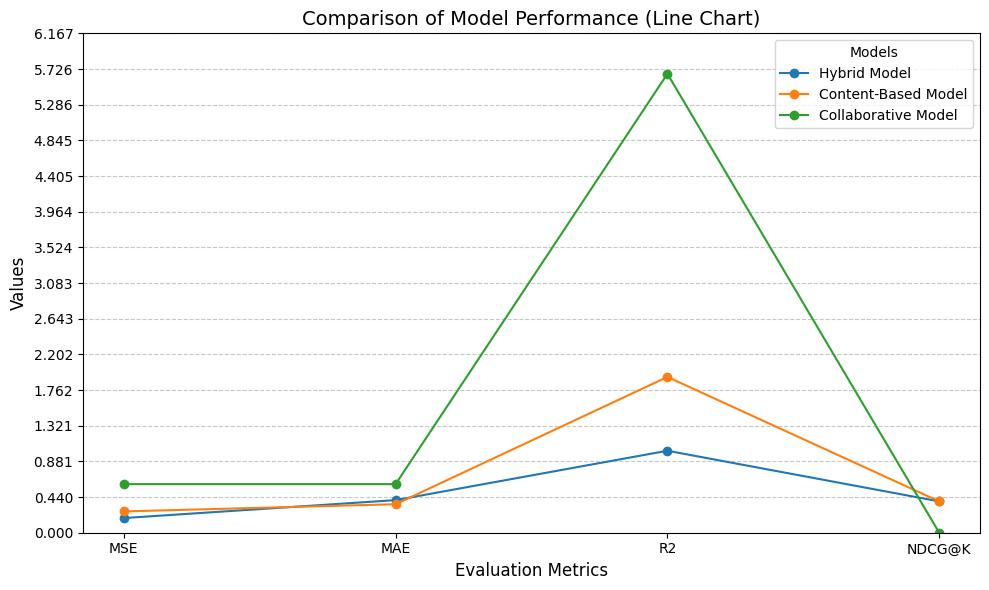

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# داده‌های مربوط به معیارهای ارزیابی
results = {
    "Hybrid Model": {"MSE": 0.1811, "MAE": 0.4025, "R2": 1.0124, "NDCG@K": 0.3869},
    "Content-Based Model": {"MSE": 0.2631, "MAE": 0.3519, "R2": 1.9238, "NDCG@K": 0.3869},
    "Collaborative Model": {"MSE": 0.6000, "MAE": 0.6000, "R2": 5.6667, "NDCG@K": 0.0000},
}

# استخراج داده‌ها
metrics = list(next(iter(results.values())).keys())
models = list(results.keys())
data = np.array([[results[model][metric] for metric in metrics] for model in models])

# تنظیم اندازه نمودار
plt.figure(figsize=(10, 6))

# رسم نمودار مقایسه خطی
for i, model in enumerate(models):
    plt.plot(metrics, data[i], marker='o', label=model)

# افزودن توضیحات
plt.xlabel("Evaluation Metrics", fontsize=12)
plt.ylabel("Values", fontsize=12)
plt.title("Comparison of Model Performance (Line Chart)", fontsize=14)
plt.legend(title="Models")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# تنظیم محدوده و درجه‌بندی محور Y
y_ticks = np.linspace(0, max(data.flatten()) + 0.5, 15)  # درجه‌بندی دقیق‌تر
plt.yticks(y_ticks, fontsize=10)
plt.ylim(0, max(data.flatten()) + 0.5)

# نمایش نمودار
plt.tight_layout()
plt.show()
